In [1]:
import matplotlib.pyplot as plt
from numpy import genfromtxt
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.ticker as mticker
import os

headers = ["event_id", "track_id", "type", "x", "y", "z", "delta_E", "process"]


def proc_file(energy):
    filepath = os.path.join(os.getcwd(), f"spectrum/{energy}/proc.txt")
    with open(f'spectrum/{energy}/log.txt', 'r') as f:
        with open(filepath, 'w') as new_f:
            for i, line in enumerate(f):
                if "ProcName" in line:
                    new_f.write(line)
                    

# generate process name files
for i in os.listdir("spectrum/"):
    if os.path.isfile(f"spectrum/{i}/log.txt"):
        proc_file(i)

def proc_list(energy, my_data):
    proc = []
    with open(f'spectrum/{energy}/proc.txt', 'r') as f:
        for i, line in enumerate(f):
            #print(my_data[i], line.split()[3])
            proc.append(line.split()[3])
            #if i > 5:
            #    break
    return proc



In [2]:
## below is from prev scripts
def search_for_thing(column, search_param, my_data):
    electron_array = []
    for i in range(len(my_data.T[0])):
        if my_data.T[column][i] == search_param:
            electron_array.append(my_data[i])
    if len(electron_array) == 0:
        print("Couldn't find anything with", headers[column], f"= {search_param}")
    else: 
        print(headers[column], f" = {search_param}")
    return np.array(electron_array)


def find_electrons(my_data):
    arr = search_for_thing(2, 1, my_data) # look for electrons
    plt.scatter(arr.T[0], arr.T[1])
    plt.xlabel("event_id")
    plt.ylabel("track_id")
    
def integrate_over(event_num, track_num, data, param = 6):
    integrate = 0
    for i in range(len(data)):
        if data.T[0][i] == event_num and data.T[1][i] == track_num:
            integrate = integrate + data.T[param][i]
    return [event_num, track_num, integrate]

def integrate_over(event_num, track_num, data, param = 6, subtract = None):
    integrate = 0
    for i in range(len(data)):
        if data.T[0][i] == event_num and data.T[1][i] == track_num:
            if not subtract:
                integrate = integrate + data.T[param][i]
            if subtract:
                ## Need to check case where next track occurs but same event
                if data.T[0][i - 1] == event_num and data.T[1][i - 1] == track_num:
                    integrate = integrate + data.T[param][i] - data.T[param][i - 1]
                else:
                    integrate = integrate + 0
    return [event_num, track_num, integrate]
    
    
def track_length_and_energy(my_data):
    # integrate energy data over track_id, event_id
    integrated_energy_by_event = []
    integrated_length_by_event_x = []
    integrated_length_by_event_y = []
    integrated_length_by_event_z = []
    for event in range(0, 20):
        for track in range(0, 20):
            integrated_energy_by_event.append(integrate_over(event, track, my_data))
            # get track lengths, `subtract = 1` shows delta track length
            integrated_length_by_event_x.append(integrate_over(event, track, my_data, param = 3, subtract = 1))
            integrated_length_by_event_y.append(integrate_over(event, track, my_data, param = 4, subtract = 1))
            integrated_length_by_event_z.append(integrate_over(event, track, my_data, param = 5, subtract = 1))

    ## convert to np arrays
    integrated_energy_by_event = np.array(integrated_energy_by_event)
    integrated_length_by_event_x = np.array(integrated_length_by_event_x)
    integrated_length_by_event_y = np.array(integrated_length_by_event_y)
    integrated_length_by_event_z = np.array(integrated_length_by_event_z)

    ## find magnitude of track lengths
    integrated_length_by_event = np.sqrt((integrated_length_by_event_x.T[2])**2 + (integrated_length_by_event_y.T[2])**2 + (integrated_length_by_event_z.T[2])**2)
    return integrated_length_by_event, integrated_energy_by_event




In [3]:
def search_for_proc(search_param, proc_list, my_data):
    proc_name = []
    for i in range(len(proc_list)):
        #print(proc_list[i])
        if proc_list[i] == search_param:
            proc_name.append(my_data[i])
            #print(proc_list[i])
    if len(proc_name) == 0:
        print("Couldn't find anything with", "process", f"= {search_param}")
    else: 
        print("ProcName", f"= {search_param}")
    return np.array(proc_name)

ProcName = eIoni


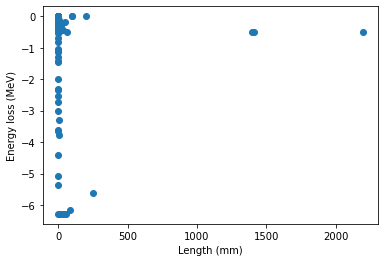

In [4]:
my_data = genfromtxt(f'spectrum/6283.8/run_nt_Hits_t0.csv', delimiter=',')

proc = proc_list(6283.8, my_data)

eioni = search_for_proc("eIoni", proc, my_data)

length, energy = track_length_and_energy(eioni)

plt.scatter(length, energy.T[2])
plt.xlabel("Length (mm)")
plt.ylabel("Energy loss (MeV)")
plt.show()

In [115]:
import pandas as pd
import itertools

my_data = genfromtxt(f'spectrum/6283.8/run_nt_Hits_t0.csv', delimiter=',')
proc = proc_list(6283.8, my_data)


eioni = search_for_proc("eIoni", proc, my_data)
eioni = search_for_thing(0, 0, eioni)

print(headers)
#print(eioni)
  
# creating a list of index names

track_event = []
pos_array = []
letterid = ["a", "b", "c"]

for i, val in enumerate(eioni):
    ide = str(i) + "__" + str(int(val[0])) + "_" + str(int(val[1]))
    track_event.append(ide)
    pos_array.append(val[3:6])

pos_array = np.array(pos_array).T


#pos_array.T[0] = [0.0, 0.0, 1010.0]
# creating a list of column names
column_values = ['x', 'y', 'z']
# creating the dataframe
df = pd.DataFrame(data = pos_array, 
                  index = column_values, 
                  columns = track_event)
  

ProcName = eIoni
event_id  = 0
['event_id', 'track_id', 'type', 'x', 'y', 'z', 'delta_E', 'process']


In [116]:
def subtractions_of_combinations(df):
    # Extract all the combinations
    combinations = list(itertools.permutations(df.columns, 2)) 
    # Calculate the two possible subtractions for each combination
    new_df = pd.DataFrame()
    for a, b in combinations:
        diff = df[a] - df[b]
        if diff["x"] > 10.0 or diff["y"] > 10.0 or diff["z"] > 10.0:
            new_df[f'{a}-{b}'] = diff
        diff = 0
    return new_df

newdf = subtractions_of_combinations(df)

newdf

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{a}-{b}'] = diff
/var/folders/6p/h1y3sh3s22dbsx_k6l69dsn00000gn/T/ipykernel_8325/2207244306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

,0__0_6-6__0_4,0__0_6-7__0_4,0__0_6-8__0_4,0__0_6-9__0_4,0__0_6-10__0_4,0__0_6-11__0_4,0__0_6-25__0_7,0__0_6-26__0_7,0__0_6-27__0_7,0__0_6-28__0_13,...,60__0_2-39__0_10,60__0_2-40__0_10,60__0_2-41__0_10,60__0_2-42__0_10,60__0_2-43__0_9,60__0_2-44__0_9,60__0_2-45__0_9,60__0_2-46__0_8,60__0_2-47__0_8,60__0_2-48__0_8
x,-2.81770,-2.80190,-2.79430,-2.78790,-2.78710,-2.78710,-33.63890,-34.85930,-38.22720,-38.49240,...,-19.737563,-19.739763,-19.739663,-19.739663,-18.539663,-18.539663,-18.539663,-3.699893,-3.699893,-3.699893
y,14.10054,14.10544,14.10444,14.09994,14.10734,14.10734,38.15644,40.02974,33.13214,33.10404,...,43.492148,43.492448,43.491948,43.491948,41.569548,41.569548,41.569548,11.332948,11.332948,11.332948
z,-5.20000,-5.21000,-5.22000,-5.23000,-5.22000,-5.22000,-47.18000,-49.79000,-55.23000,-55.43000,...,-43.990000,-43.990000,-43.990000,-43.990000,-41.330000,-41.330000,-41.330000,-10.870000,-10.870000,-10.870000


In [119]:
track_list = []

for i in newdf.keys():
    track_list.append(i)

unique_tracks = np.empty((len(track_list), 2))
for j, track in enumerate(track_list):
    #unique_tracks.append(j.split("-"))
    temp = track.split("-")
    for k, val in enumerate(temp):
        unique_tracks[j][k] = val.split("__")[1]

unique_tracks = tuple(map(tuple, unique_tracks))

i = 0
final = []
for i in unique_tracks:
    if i not in final and tuple(reversed(i)) not in final:
        final.append(i)

print(final)
print(len(final))

[(6.0, 4.0), (6.0, 7.0), (6.0, 13.0), (6.0, 12.0), (6.0, 11.0), (6.0, 10.0), (6.0, 9.0), (5.0, 4.0), (5.0, 7.0), (5.0, 13.0), (5.0, 12.0), (5.0, 11.0), (5.0, 10.0), (5.0, 9.0), (4.0, 7.0), (4.0, 13.0), (4.0, 12.0), (4.0, 11.0), (4.0, 10.0), (4.0, 9.0), (3.0, 6.0), (3.0, 5.0), (3.0, 4.0), (3.0, 7.0), (3.0, 13.0), (3.0, 12.0), (3.0, 11.0), (3.0, 10.0), (3.0, 9.0), (3.0, 8.0), (7.0, 8.0), (7.0, 2.0), (13.0, 8.0), (13.0, 2.0), (12.0, 8.0), (12.0, 2.0), (11.0, 8.0), (11.0, 2.0), (10.0, 8.0), (10.0, 2.0), (9.0, 8.0), (9.0, 2.0), (8.0, 6.0), (8.0, 5.0), (8.0, 4.0), (8.0, 2.0), (2.0, 6.0), (2.0, 5.0), (2.0, 4.0)]
49


In [120]:
df

,0__0_6,1__0_6,2__0_6,3__0_5,4__0_5,5__0_5,6__0_4,7__0_4,8__0_4,9__0_4,...,51__0_2,52__0_2,53__0_2,54__0_2,55__0_2,56__0_2,57__0_2,58__0_2,59__0_2,60__0_2
x,-15.24350,-15.24440,-15.24530,-16.43600,-16.43550,-16.43550,-12.4258,-12.4416,-12.4492,-12.4556,...,-0.049199,0.055532,-0.148745,-0.136015,-0.146944,-0.140719,-0.140544,-0.144326,-0.144263,-0.144263
y,-3.07676,-3.08162,-3.08257,-1.18602,-1.18362,-1.18362,-17.1773,-17.1822,-17.1812,-17.1767,...,0.304263,0.388169,0.386663,0.360678,0.340864,0.331808,0.336456,0.336332,0.336348,0.336348
z,1032.64000,1032.64000,1032.64000,1031.28000,1031.27000,1031.27000,1037.8400,1037.8500,1037.8600,1037.8700,...,1038.390000,1038.440000,1038.500000,1038.490000,1038.500000,1038.490000,1038.500000,1038.490000,1038.490000,1038.490000
